In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from pathlib import Path
import os
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import f1_score
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier
from model_utils import train_classifier, plot_report, compare_train_test_performance
from fastai.tabular.all import *

## Read the data

The training and test datasets are stored in separate files

In [2]:
data_path = Path("./data/matched_w_features/")

train_data = gpd.read_parquet(data_path/"train_data.parquet")
train_info = train_data.iloc[:,:20]
train_features = train_data.iloc[:,20:]

test_data = gpd.read_parquet(data_path/"test_data.parquet")
test_info = test_data.iloc[:,:20]
test_features = test_data.iloc[:,20:]

Create dataloaders for the training and test datasets

In [3]:
# Combine the training features with the targets
train_data = train_features.merge(train_info.species, left_index = True, right_index = True).sample(frac = 1, random_state = 3)

# Compute the feature means and standard deviations for standardization
stats = np.array([train_features.values.mean(axis = 0), train_features.values.std(axis = 0)])

# Create a dataloader for the datasets
dl = TabularDataLoaders.from_df(df = train_data,
                                procs = [Normalize.from_stats(*stats)],
                                y_names = ["species"],
                                y_block = CategoryBlock,
                                valid_idx = np.arange(-1667,-1))

test_dl = dl.test_dl(test_features)
                                     

## Train the deadwood model

Train a fastai tabular learner (an artificial neural network)

epoch,train_loss,valid_loss,f1_score,precision_score,recall_score,cohen_kappa_score,matthews_corrcoef,time
0,0.702778,0.555726,0.419592,0.548536,0.549201,0.318468,0.361116,00:02
1,0.479024,0.424149,0.526774,0.598008,0.650747,0.453629,0.482415,00:02
2,0.384035,0.345175,0.617111,0.634119,0.745493,0.591991,0.601452,00:02
3,0.400265,0.362232,0.574787,0.632368,0.692096,0.522100,0.543129,00:02
4,0.330927,0.297502,0.592376,0.636941,0.709945,0.552296,0.568177,00:02
5,0.261908,0.350177,0.610505,0.660042,0.725530,0.584592,0.601100,00:02
6,0.327138,0.283259,0.617097,0.663635,0.737368,0.578531,0.597617,00:02
7,0.313675,0.255818,0.625234,0.666611,0.737991,0.614474,0.625903,00:02
8,0.309627,0.235523,0.636553,0.665945,0.762707,0.616001,0.629031,00:02
9,0.266003,0.361954,0.559911,0.650506,0.668912,0.523339,0.547077,00:02


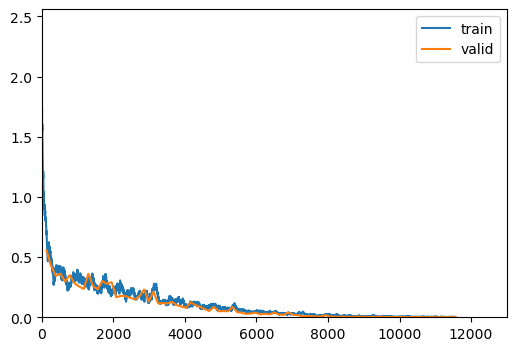

No improvement since epoch 81: early stopping


In [4]:
metrics = [F1Score(average='macro'),
           Precision(average='macro'),
           Recall(average='macro'),
           CohenKappa(),
           MatthewsCorrCoef()]
learn = tabular_learner(dl, 
                        metrics = metrics, 
                        cbs = [ShowGraphCallback(), EarlyStoppingCallback(monitor = "valid_loss",patience = 8)],
                        loss_func = CrossEntropyLossFlat(weight = torch.Tensor([1,1,1,1,1e10])),
                        )
                                
learn.fit_one_cycle(100)

Evaluate its performance on the test set

                precision    recall  f1-score   support

         Birch       0.46      0.62      0.52       188
European aspen       0.81      0.70      0.75       281
 Norway spruce       0.54      0.45      0.49       284
    Scots pine       0.77      0.83      0.80       527
      deadwood       0.50      0.25      0.33        48

      accuracy                           0.67      1328
     macro avg       0.62      0.57      0.58      1328
  weighted avg       0.68      0.67      0.67      1328

Cohen's kappa: 0.55
Matthews correlation coefficient: 0.55


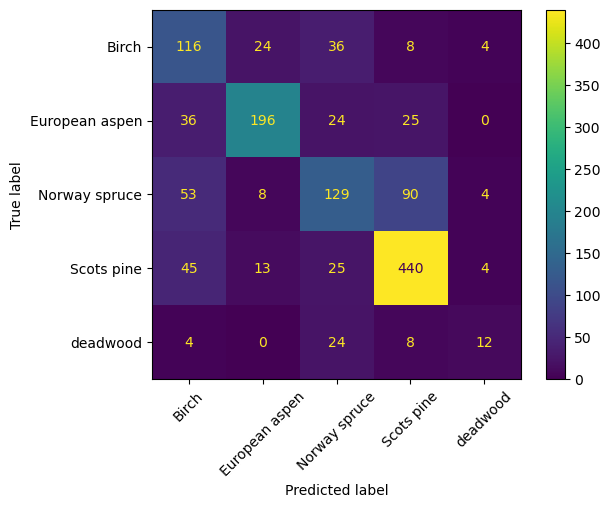

In [5]:
prob, _ = learn.get_preds(dl = test_dl)
y_hat = pd.Series(dl.vocab[np.argmax(prob, axis = 1)])
plot_report(test_info.species, y_hat)

In [6]:
learn.export("./models/deadwood_model.pkl")

## Train the general model

epoch,train_loss,valid_loss,f1_score,precision_score,recall_score,cohen_kappa_score,matthews_corrcoef,time
0,0.859642,0.737604,0.714154,0.759500,0.693764,0.717626,0.718636,00:02
1,0.670042,0.567730,0.782359,0.850348,0.759171,0.803598,0.804513,00:02
2,0.574609,0.524838,0.819144,0.859778,0.800688,0.798189,0.798833,00:02
3,0.493061,0.442097,0.800135,0.858150,0.775449,0.809832,0.809903,00:02
4,0.413922,0.358283,0.866459,0.912021,0.841183,0.857401,0.857505,00:02
5,0.400322,0.344201,0.858274,0.917669,0.829405,0.863918,0.864554,00:02
6,0.353354,0.290837,0.888482,0.929626,0.864711,0.886281,0.886632,00:02
7,0.326645,0.247119,0.894084,0.924729,0.874162,0.900314,0.900849,00:02
8,0.310934,0.240704,0.895116,0.944531,0.867023,0.902639,0.903332,00:02
9,0.286175,0.212038,0.909848,0.921221,0.901033,0.902174,0.902436,00:02


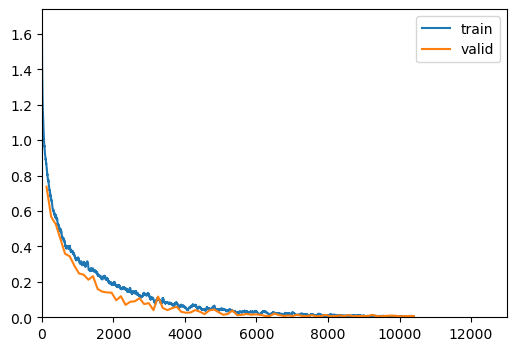

No improvement since epoch 72: early stopping


In [9]:
metrics = [F1Score(average='macro'),
           Precision(average='macro'),
           Recall(average='macro'),
           CohenKappa(),
           MatthewsCorrCoef()]
learn = tabular_learner(dl, 
                        metrics = metrics, 
                        cbs = [ShowGraphCallback(), EarlyStoppingCallback(monitor = "valid_loss",patience = 8)])
                                
learn.fit_one_cycle(100)

                precision    recall  f1-score   support

         Birch       0.43      0.53      0.47       188
European aspen       0.82      0.64      0.72       281
 Norway spruce       0.56      0.48      0.52       284
    Scots pine       0.74      0.86      0.80       527
      deadwood       0.50      0.17      0.25        48

      accuracy                           0.66      1328
     macro avg       0.61      0.54      0.55      1328
  weighted avg       0.66      0.66      0.65      1328

Cohen's kappa: 0.53
Matthews correlation coefficient: 0.53


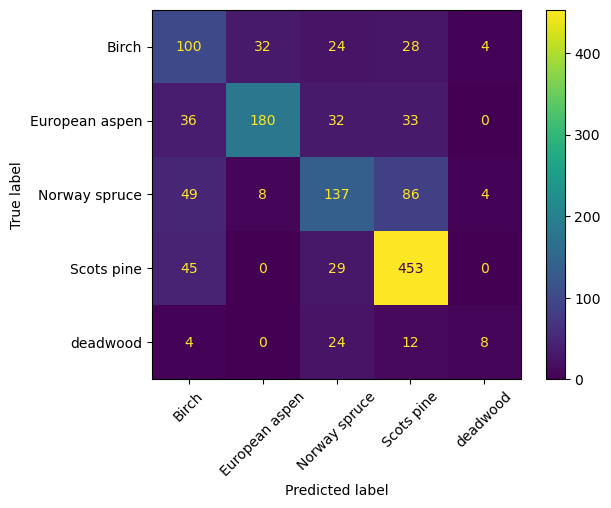

In [10]:
prob, _ = learn.get_preds(dl = test_dl)
y_hat = pd.Series(dl.vocab[np.argmax(prob, axis = 1)])
plot_report(test_info.species, y_hat)

In [11]:
learn.export("./models/general_model.pkl")